In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.get_session()
K.set_session(sess)

In [3]:
# test harness for evaluating models on the cifar10 dataset
import sys
import numpy as np

from matplotlib import pyplot as plt
from keras.datasets import cifar10, cifar100
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

from keras import backend as K



In [4]:
#check if GPU available 
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.plot()
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    # save plot to file
    plt.show()
    
    
    plt.plot()
    plt.title('Classification Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    # save plot to file
    plt.show()
    
    
    plt.plot()
    plt.title('Classification F1')
    plt.plot(history.history['f1_'], color='blue', label='train')
    plt.plot(history.history['val_f1_'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('F1')
    plt.legend()
    # save plot to file
    plt.show()
    
    
    plt.plot()
    plt.title('Classification Precision')
    plt.plot(history.history['precision_'], color='blue', label='train')
    plt.plot(history.history['val_precision_'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('precision')
    plt.legend()
    # save plot to file
    plt.show()
    
    plt.plot()
    plt.title('Classification Recall')
    plt.plot(history.history['recall_'], color='blue', label='train')
    plt.plot(history.history['val_recall_'], color='orange', label='test')
    plt.xlabel('epoch')
    plt.ylabel('recall')
    plt.legend()
    # save plot to file
    plt.show()
    

In [7]:
# load train and test dataset
def load_dataset10():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode target values
    trainY = to_categorical(trainY, num_classes=75)
    testY = to_categorical(testY, num_classes=75)
    return trainX, trainY, testX, testY

def load_dataset100():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar100.load_data()
    # one hot encode target values
#     trainY = to_categorical(trainY)
#     testY = to_categorical(testY)
    return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

# run the test harness for evaluating a model
def run_test():
    # load dataset
    trainX, trainY, testX, testY = load_dataset10()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    
    
    trainX100, trainY100, testX100, testY100 = load_dataset100()
    # prepare pixel data
    trainX100, testX100 = prep_pixels(trainX, testX)
        
    arr_x = []
    arr_y = []
    for i in range(trainY100.size-1):
        if(trainY100[i]>=70 and trainY100[i]<=74):
            arr_x.append(trainX100[i])        
            arr_y.append(trainY100[i])
    
    arr_x = np.array(arr_x)
    arr_y = np.array(arr_y)
    arr_y = to_categorical(arr_y)
    trainX = np.vstack([trainX, arr_x])
    trainY = np.vstack([trainY, arr_y])
    

    arr_x = []
    arr_y = []
    for i in range(testY100.size-1):
        if(testY100[i]>=70 and testY100[i]<=74):
            arr_x.append(testX100[i])        
            arr_y.append(testY100[i])

    arr_x = np.array(arr_x)
    arr_y = np.array(arr_y)
    arr_y = to_categorical(arr_y)
    testX = np.vstack([testX, arr_x])
    testY = np.vstack([testY, arr_y])

    
    
    
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=64, validation_data=(testX, testY), verbose=1)
    # evaluate model
    loss, accuracy, f1_score, precision, recall = model.evaluate(testX, testY, verbose=0)
    print()
    print('accuracy > %.3f' % (accuracy * 100.0))
    print('loss > %.3f' % (loss * 100.0))
    print('f1 > %.3f' % (f1_score * 100.0))
    print('precision > %.3f' % (precision * 100.0))
    print('recall > %.3f' % (recall * 100.0))

    # learning curves
    summarize_diagnostics(history)
    model.save('./model/model_CIFAR100.h5')
    print("I am done")

In [8]:
def define_model():
    model = load_model('./model/model_CIFAR10_dropout.h5', custom_objects={'f1_': f1_,'precision_': precision_,'recall_': recall_})

    model.pop() #remove the last layer - 'Dense' layer with 10 units

    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(units = 75, activation = 'softmax', name = 'lastLayer'))

    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_, precision_, recall_])
    return model

Epoch 1/10
821/821 [==============================] - 7s 9ms/step - loss: 1.2864 - accuracy: 0.6504 - f1_: 0.5928 - precision_: 0.8374 - recall_: 0.4786 - val_loss: 0.7804 - val_accuracy: 0.7565 - val_f1_: 0.7210 - val_precision_: 0.8323 - val_recall_: 0.6386
Epoch 2/10
821/821 [==============================] - 7s 8ms/step - loss: 0.7274 - accuracy: 0.7585 - f1_: 0.7529 - precision_: 0.8777 - recall_: 0.6609 - val_loss: 0.6967 - val_accuracy: 0.7649 - val_f1_: 0.7425 - val_precision_: 0.8251 - val_recall_: 0.6776
Epoch 3/10
821/821 [==============================] - 7s 9ms/step - loss: 0.6686 - accuracy: 0.7696 - f1_: 0.7674 - precision_: 0.8720 - recall_: 0.6864 - val_loss: 0.6695 - val_accuracy: 0.7687 - val_f1_: 0.7492 - val_precision_: 0.8215 - val_recall_: 0.6911
Epoch 4/10
821/821 [==============================] - 7s 8ms/step - loss: 0.6338 - accuracy: 0.7783 - f1_: 0.7792 - precision_: 0.8743 - recall_: 0.7040 - val_loss: 0.6564 - val_accuracy: 0.7708 - val_f1_: 0.7532 - val_p

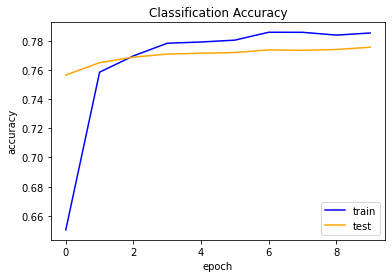

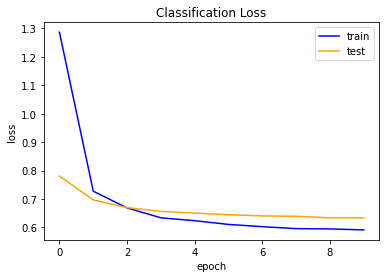

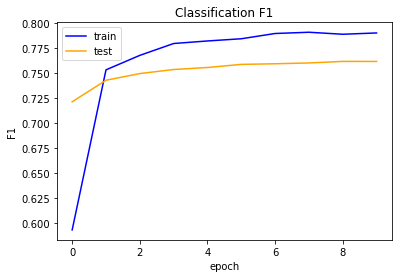

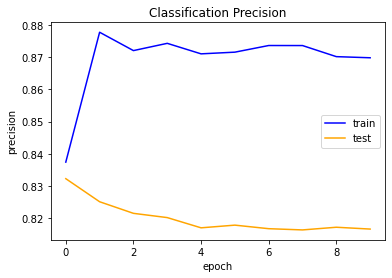

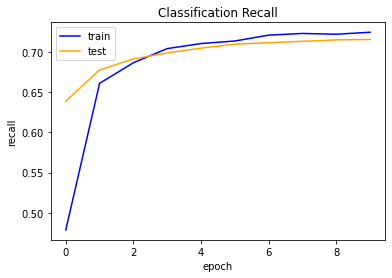

I am done


In [9]:

# entry point, run the test harness

run_test()

In [ ]:
print(define_model().summary())